In [1]:
# Calculate heat budget terms
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import os, sys

In [2]:
# Calculate volume temperature for the Storage term dT/dt
def vol_temp(datapath, case_id, xi):
    
    State0 = xr.open_dataset(datapath+'/state_' + str(format(case_id,'03d')) + '.nc')
    Grid = xr.open_dataset(datapath+'/grid_' + str(format(case_id,'03d')) + '.nc')
    State = State0.isel(T=~State0.get_index("T").duplicated())    
    # Confine to the range of fjord
    state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45))
    grid = Grid.isel(X=range(260), Xp1=range(261), Y=range(35,45))

    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2 # Along-channel velocity
    Time = state.T.data
    
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC

    rA = np.broadcast_to(grid.rA.data[np.newaxis, np.newaxis, :, :], U.shape)
    CV = rA * drF * HFacC
    
    da = DA[:,:,:,xi[0]+1:xi[1]+1].mean(2)
    cv = CV[:,:,:,xi[0]+1:xi[1]+1].mean(2)
    s = state.S.data[:,:,:,xi[0]+1:xi[1]+1].mean(2)
    temp = state.Temp.data[:,:,:,xi[0]+1:xi[1]+1].mean(2)
    u = U[:,:,:,xi[0]+1:xi[1]+1].mean(2)
    sma = np.ma.masked_where(s==0, s)
    topo = np.ma.getmask(sma) # Masked Topography
    uma = np.ma.MaskedArray(u, mask=topo)
    tma = np.ma.MaskedArray(temp, mask=topo)
    
    
    vTemp1 = np.empty(len(Time))
    vTemp2 = np.empty(len(Time))
    Tvol = np.empty(len(Time))
    
    for tt in range(len(Time)):
        
        Temp_t = temp[tt,:,:]
        U_t = u[tt,:,:]
        Area_t = da[tt,:,:]
        Vol_t = cv[tt,:,:]
        
        xTemp1 = np.empty(Temp_t.shape[1])
        xTemp2 = np.empty(Temp_t.shape[1]
                         )
        for i in range(Temp_t.shape[1]):

            xTemp1[i] = np.sum(Temp_t[:,i]*Area_t[:,i]*U_t[:,i]) / np.sum(Area_t[:,i]*U_t[:,i])
            xTemp2[i] = np.sum(Temp_t[:,i]*Area_t[:,i]) / np.sum(Area_t[:,i])
            Tvol[i] = Vol_t[:,i].sum()
            
        vTemp1[tt] = xTemp1[:-1].mean() # Average in x direction
        vTemp2[tt] = xTemp2[:-1].mean()
        Volume = Tvol[:-1].sum()
        
    return vTemp1, vTemp2, Volume

In [ ]:
#np.arange(121) /2 

In [3]:
path1 = '/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase'
case = np.array([1, 2, 3, 4, 5, 6])
hsr = np.array([0.04,0.06,0.08,0.10,0.12,1])
#xrange = np.array([120,235]) # X index range for the sill segment between S1 S2
#xrange = np.array([6,121]) # X index range for the fjord segment between S0 S1
xrange = np.array([0,121]) # X index range for the sill segment between S1 S2

time = np.arange(121)/2 # days

Tv1 = np.empty([len(case), len(time)])
Tv2 = np.empty([len(case), len(time)])

for j in range(len(case)):
    vTemp1, vTemp2, Vol = vol_temp(path1,case[j],xrange)
    Tv1[j,:] = vTemp1
    Tv2[j,:] = vTemp2

/home/1959/local/bin/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


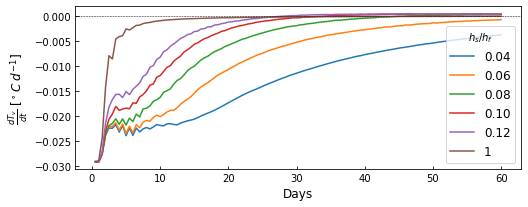

In [10]:
fig1 = plt.figure(figsize=(8,3))    
ax1 = fig1.add_subplot(111)

dt = .5 # time interval of 0.5 day
ax1.plot(time[1:],np.diff(Tv2[0,:])/dt,'-',label='0.04')
ax1.plot(time[1:],np.diff(Tv2[1,:])/dt,'-',label='0.06')
ax1.plot(time[1:],np.diff(Tv2[2,:])/dt,'-',label='0.08')
ax1.plot(time[1:],np.diff(Tv2[3,:])/dt,'-',label='0.10')
ax1.plot(time[1:],np.diff(Tv2[4,:])/dt,'-',label='0.12')
ax1.plot(time[1:],np.diff(Tv2[5,:])/dt,'-',label='1')
ax1.axhline(y=0, color='k',linestyle='--', linewidth=.5)
ax1.legend(title='$h_s/h_f$',loc='best',fontsize=12)

ax1.tick_params(direction='in', labelsize=10)
ax1.set_xlabel('Days',fontsize=12)
ax1.set_ylabel(r'$\frac{dT_v}{dt}$ [$^\circ C\;d^{-1}$]',fontsize=12)

fig1.savefig('/home/1959/Jupyter_Figs/FjordModeling//dTdt_GfS1.png', dpi=300, bbox_inches='tight') 

In [6]:
# Advective temeprature flux from model diagnostics
def H_Adv(datapath, case_id, xi):
    
    file0 = xr.open_dataset(datapath+'/Adv_' + str(format(case_id,'03d')) + '.nc')
    file1 = file0.isel(T=~file0.get_index("T").duplicated())
    state = file1.isel(X=range(260), Xp1=range(261), Y=range(35,45), Yp1=range(35,46))
     
    hadv_l = np.empty(len(state.T.data))
    hadv_r = np.empty(len(state.T.data))
    
    for i in range(len(state.T.data)):
        hadv_l[i] = state.ADVx_TH.data[i,:,:,xi[0]].sum() # left boundary
        hadv_r[i] = state.ADVx_TH.data[i,:,:,xi[-1]].sum() # right boundary
        
    return hadv_l, hadv_r

In [7]:
Hadv_l = np.empty(len(case))
Hadv_r = np.empty(len(case))

for j in range(len(case)):
    hadv1, hadv2 = H_Adv(path1,case[j],xrange)
    Hadv_l[j] = hadv1[-28:].mean()
    Hadv_r[j] = hadv2[-28:].mean()

In [8]:
Hsto = np.empty(len(case))
for i in range(len(case)):
    Hsto[i] = np.diff(Tv2[i,-28:]).mean()/(dt*24*3600) *Vol
Hsto

array([-52.91426093, -12.43332345,   2.55327523,   5.0415606 ,
         5.23597638,  -0.34178048])

In [8]:
Hadv_l, Hadv_r, Hadv_l-Hadv_r

(array([0., 0., 0., 0., 0., 0.]),
 array([-308.80046735, -771.40722656, -910.26213728, -947.35239955,
        -973.69419643, -781.39090402]),
 array([308.80046735, 771.40722656, 910.26213728, 947.35239955,
        973.69419643, 781.39090402]))

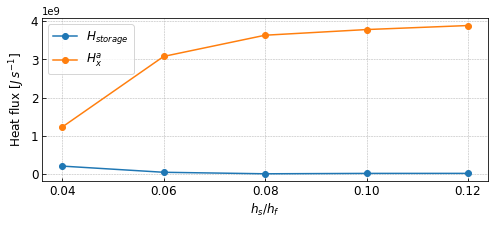

In [9]:
Cp = 3994  # Specific heat content J/kg/C
rho = 999.8 # Density

fig2 = plt.figure(figsize=(8,3))    
ax1 = fig2.add_subplot(111)

ax1.plot(hsr[:-1],np.abs(Hsto[:-1])*Cp*rho,'o-',label='$H_{storage}$')
ax1.plot(hsr[:-1],np.abs(Hadv_l[:-1]-Hadv_r[:-1])*Cp*rho,'o-',label='$H^a_x$')
ax1.legend(loc='best',fontsize=12)
plt.grid(linestyle = '--', linewidth = 0.5)
#ax1.set_ylim([0, 4e9])
ax1.set_xticks([0.04, 0.06, 0.08, 0.10, 0.12])
ax1.tick_params(direction='in', labelsize=12)
ax1.set_xlabel(r'$h_s/h_f$',fontsize=12)
ax1.set_ylabel(r'Heat flux [$J\;s^{-1}$]',fontsize=12)

fig2.savefig('/home/1959/Jupyter_Figs/FjordModeling//Heat_term_comp.png', dpi=300, bbox_inches='tight') 

In [12]:
2**(-7/8)*(np.pi**(-1/4))

0.40955410722071084